In [1]:
#!/usr/bin/python

In [2]:
import sqlite3
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def check_blankTimestamp(df):
    print (df.shape)
    var1 = df['TIME'] == ""
    df1 = df[var1]
    print (df1)

In [4]:
def set_time_as_index(df):
    df['TIME'] = df['TIME'].values.astype('<M8[m]')
    df['TIME'] = pd.to_datetime(df['TIME'])
    df = df.set_index('TIME')
    return df

In [5]:
def remove_duplicate_index(df):
    print (df.index.get_duplicates())
    print(len(df.index.get_duplicates()))
    df = df[~df.index.duplicated(keep='last')]
    print(len(df.index.get_duplicates()))
    return df

In [6]:
def get_data_for_corresponding_meter(meter_id, start_date, df_irr):
    conn = sqlite3.connect('/home/bosch/simran/Solar_Jaipur.db')
    df_solar = pd.read_sql_query("Select id, time, activepower, realtime_e, meter_id from RS485SAMPLES where meter_id = " + meter_id, conn)
    print (df_solar.shape)
    df_solar = df_solar[df_solar['TIME'] > start_date]
    end_date = '2018-06-28 11:19:00'
    df_solar = df_solar[df_solar['TIME'] < end_date]
    print (df_solar.shape)
    df_solar['ACTIVEPOWER'] = df_solar['ACTIVEPOWER']/1000 #changing it from Watts to kiloWatts
    df_solar.drop(('ID'), axis=1, inplace=True)
    df_solar.drop(('REALTIME_E'), axis=1, inplace=True)
    df_solar.drop(('METER_ID'), axis=1, inplace=True)
    check_blankTimestamp(df_solar)
    df_solar = set_time_as_index(df_solar)
    df_solar = remove_duplicate_index(df_solar)
    print (df_solar.shape)
    df_solar = df_solar.resample('min').interpolate(method='linear')
    print (df_solar.shape)
    df_solar['IRRADIANCE'] = df_irr['PC']
    return df_solar    

In [7]:
def resample_minute_to_hour_meter_data(df_solar):
    df_solar_hourly = df_solar.resample('H').mean() # 880 rows
    df_solar_hourly = df_solar_hourly.dropna() #No change
    return df_solar_hourly

In [8]:
def group_by_hour(df_solar_hourly):
    df = df_solar_hourly
    df = df.groupby(df.index.hour).mean()
    return df

In [9]:
def read_dataframe_from_database(meter_ids, start_date, df_irr):
    
    meter_df_dict = dict()
    for meter_id, name in meter_ids.items():
        print (meter_id)
        df_solar = get_data_for_corresponding_meter(meter_id, start_date, df_irr)
        df_solar_hourly = resample_minute_to_hour_meter_data(df_solar)
        df = group_by_hour(df_solar_hourly)
        meter_df_dict[meter_id]= df

    return meter_df_dict

In [10]:
def get_max_min_ACTIVEPOWER_hourly(meter_ids, start_date, df_irr):
    meter_df_dict = dict()
    for meter_id, name in meter_ids.items():
        print (meter_id)
        df_solar = get_data_for_corresponding_meter(meter_id, start_date, df_irr)
        df_max_min = df_solar.resample('H')['ACTIVEPOWER'].agg(['min', 'max'])
        df_hour_max_min = pd.DataFrame()
        df_hour_max_min['MAX ACTIVEPOWER'] = df_max_min.groupby(df_max_min.index.hour).max()["max"]
        df_hour_max_min['MIN ACTIVEPOWER'] = df_max_min.groupby(df_max_min.index.hour).min()["min"]
        meter_df_dict[meter_id] = df_hour_max_min
    
    return meter_df_dict

In [11]:
start_date = '2018-05-28 18:34:00'
conn = sqlite3.connect('/home/bosch/simran/solar_irradiance.db')
df_irr = pd.read_sql_query("Select time, pc from RS485SAMPLES", conn)
df_irr = df_irr[df_irr['TIME'] > start_date]
df_irr

,TIME,PC
101,2018-05-28 18:34:49,36.0
102,2018-05-28 18:35:49,35.0
103,2018-05-28 18:36:49,34.0
104,2018-05-28 18:37:49,33.0
105,2018-05-28 18:38:49,32.0
106,2018-05-28 18:39:49,31.0
107,2018-05-28 18:40:49,30.0
108,2018-05-28 18:41:49,29.0
109,2018-05-28 18:42:49,28.0
110,2018-05-28 18:43:49,26.0


In [12]:
check_blankTimestamp(df_irr)

(39791, 2)
Empty DataFrame
Columns: [TIME, PC]
Index: []


In [13]:
df_irr = set_time_as_index(df_irr)
df_irr

,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [14]:
df_irr = remove_duplicate_index(df_irr)
df_irr

DatetimeIndex(['2018-05-28 22:11:00', '2018-05-28 22:14:00',
               '2018-05-28 23:39:00', '2018-05-29 03:44:00',
               '2018-05-29 08:15:00', '2018-06-15 08:27:00',
               '2018-06-26 10:01:00', '2018-06-26 13:42:00',
               '2018-06-26 17:09:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
9
0


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [15]:
df_irr = df_irr.resample('min').interpolate(method='linear')
df_irr

,PC
TIME,
2018-05-28 18:34:00,36.0
2018-05-28 18:35:00,35.0
2018-05-28 18:36:00,34.0
2018-05-28 18:37:00,33.0
2018-05-28 18:38:00,32.0
2018-05-28 18:39:00,31.0
2018-05-28 18:40:00,30.0
2018-05-28 18:41:00,29.0
2018-05-28 18:42:00,28.0


In [16]:
meter_id = '5'
conn = sqlite3.connect('/home/bosch/simran/Solar_Jaipur.db')
df_solar = pd.read_sql_query("Select id, time, activepower, realtime_e, meter_id from RS485SAMPLES where meter_id = " + meter_id, conn)
print (df_solar.shape)
df_solar = df_solar[df_solar['TIME'] > start_date]
df_solar

(52729, 5)


,ID,TIME,ACTIVEPOWER,REALTIME_E,METER_ID
101,1217,2018-05-28 18:34:38,1116.0,99886816.0,5
102,1229,2018-05-28 18:35:38,1059.0,99886832.0,5
103,1241,2018-05-28 18:36:38,1018.0,99886848.0,5
104,1253,2018-05-28 18:37:38,969.0,99886872.0,5
105,1265,2018-05-28 18:38:38,930.0,99886880.0,5
106,1277,2018-05-28 18:39:38,885.0,99886896.0,5
107,1289,2018-05-28 18:40:38,837.0,99886912.0,5
108,1301,2018-05-28 18:41:38,798.0,99886928.0,5
109,1313,2018-05-28 18:42:38,747.0,99886944.0,5
110,1325,2018-05-28 18:43:38,712.0,99886952.0,5


In [17]:
df_solar.drop(('ID'), axis=1, inplace=True)
df_solar.drop(('REALTIME_E'), axis=1, inplace=True)
df_solar.drop(('METER_ID'), axis=1, inplace=True)
df_solar

,TIME,ACTIVEPOWER
101,2018-05-28 18:34:38,1116.0
102,2018-05-28 18:35:38,1059.0
103,2018-05-28 18:36:38,1018.0
104,2018-05-28 18:37:38,969.0
105,2018-05-28 18:38:38,930.0
106,2018-05-28 18:39:38,885.0
107,2018-05-28 18:40:38,837.0
108,2018-05-28 18:41:38,798.0
109,2018-05-28 18:42:38,747.0
110,2018-05-28 18:43:38,712.0


In [18]:
check_blankTimestamp(df_solar)

(52625, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []


In [19]:
df_solar = set_time_as_index(df_solar)
df_solar

,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [20]:
df_solar = remove_duplicate_index(df_solar)
df_solar

DatetimeIndex(['2018-06-17 06:07:00', '2018-06-30 15:36:00'], dtype='datetime64[ns]', name='TIME', freq=None)
2
0


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [21]:
df_solar = df_solar.resample('min').interpolate(method='linear')
df_solar

,ACTIVEPOWER
TIME,
2018-05-28 18:34:00,1116.0
2018-05-28 18:35:00,1059.0
2018-05-28 18:36:00,1018.0
2018-05-28 18:37:00,969.0
2018-05-28 18:38:00,930.0
2018-05-28 18:39:00,885.0
2018-05-28 18:40:00,837.0
2018-05-28 18:41:00,798.0
2018-05-28 18:42:00,747.0


In [22]:
df_solar['IRRADIANCE'] = df_irr['PC']
df_solar

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:34:00,1116.0,36.0
2018-05-28 18:35:00,1059.0,35.0
2018-05-28 18:36:00,1018.0,34.0
2018-05-28 18:37:00,969.0,33.0
2018-05-28 18:38:00,930.0,32.0
2018-05-28 18:39:00,885.0,31.0
2018-05-28 18:40:00,837.0,30.0
2018-05-28 18:41:00,798.0,29.0
2018-05-28 18:42:00,747.0,28.0


In [23]:
df_solar_hourly = df_solar.resample('H').mean() # 880 rows
df_solar_hourly = df_solar_hourly.dropna() #No change
df_solar_hourly

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:00:00,562.500000,22.961538
2018-05-28 19:00:00,0.216667,2.291667
2018-05-28 20:00:00,0.000000,1.000000
2018-05-28 21:00:00,0.000000,1.000000
2018-05-28 22:00:00,0.000000,1.000000
2018-05-28 23:00:00,0.000000,1.000000
2018-05-29 00:00:00,0.000000,1.000000
2018-05-29 01:00:00,0.000000,1.000000
2018-05-29 02:00:00,0.000000,1.000000


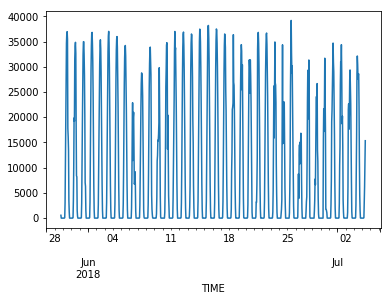

In [24]:
df_solar_hourly['ACTIVEPOWER'].plot()

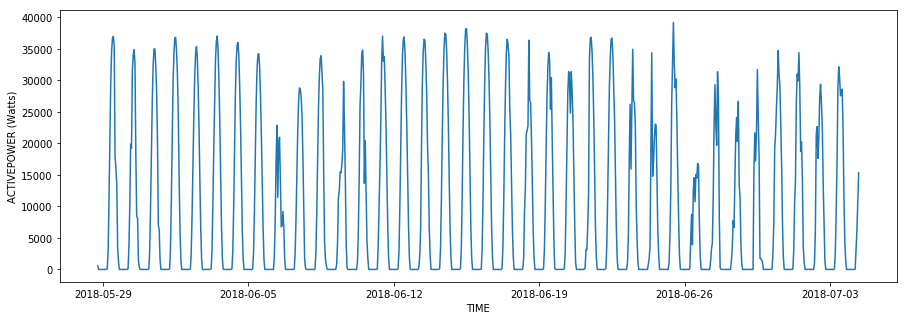

In [25]:
plt.figure(figsize=(15,5))
plt.plot(df_solar_hourly['ACTIVEPOWER'])
plt.ylabel('ACTIVEPOWER (Watts)')
plt.xlabel('TIME')
#plt.legend()
plt.show()

In [26]:
df = df_solar_hourly
df = df.groupby(df.index.hour).mean()
df

,ACTIVEPOWER,IRRADIANCE
TIME,,
0,0.000000,55.233418
1,0.000000,56.912904
2,0.000000,62.775339
3,0.000000,74.602120
4,0.000000,89.444657
5,87.600901,108.690171
6,2384.679955,162.712407
7,7933.427027,258.401759
8,16216.402928,391.701128


In [27]:
df_solar_hourly.between_time('19:00:00','19:00:00')

,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 19:00:00,0.216667,2.291667
2018-05-29 19:00:00,0.833333,2.266667
2018-05-30 19:00:00,0.000000,1.350000
2018-05-31 19:00:00,0.316667,2.466667
2018-06-01 19:00:00,3.066667,2.550000
2018-06-02 19:00:00,2.533333,238.457414
2018-06-03 19:00:00,20.566667,609.928002
2018-06-04 19:00:00,3.883333,2.966667
2018-06-05 19:00:00,6.850000,2.983333


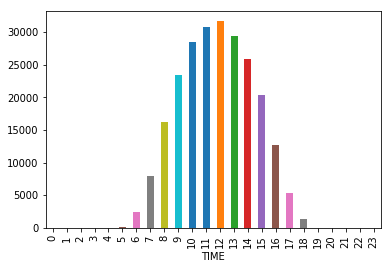

In [28]:
df['ACTIVEPOWER'].plot(kind='bar')

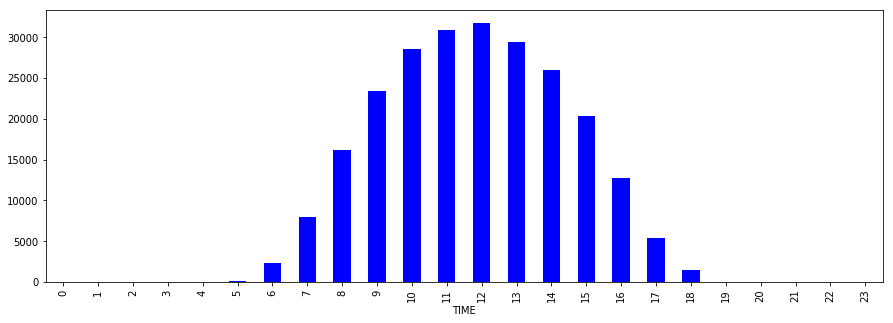

In [29]:
plt.figure(figsize=(15,5))
df['ACTIVEPOWER'].plot.bar(color='b')

In [30]:
df_solar_5 = get_data_for_corresponding_meter('5', start_date, df_irr)
df_solar_5_hourly = resample_minute_to_hour_meter_data(df_solar_5)
df_5 = group_by_hour(df_solar_5_hourly)
df_5

(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER,IRRADIANCE
TIME,,
0,0.000000,65.730208
1,0.000000,67.734757
2,0.000000,74.731856
3,0.000000,88.847691
4,0.000000,106.562978
5,0.094208,128.818914
6,2.448483,183.213733
7,8.199740,272.985971
8,16.199345,395.532529


In [31]:
meter_ids = {'5':'METER 5' , '6':'METER 6', '7':'METER 7', '8':'METER 8', '9':'METER 9', '10':'METER 10', '11':'METER 11'}
meter_ids

{'5': 'METER 5',
 '6': 'METER 6',
 '7': 'METER 7',
 '8': 'METER 8',
 '9': 'METER 9',
 '10': 'METER 10',
 '11': 'METER 11'}

In [32]:
meter_df_dict = read_dataframe_from_database(meter_ids, start_date, df_irr)

5
(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)
6


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(52729, 5)
(44073, 5)
(44073, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00', '2018-06-17 07:11:00',
               '2018-06-17 14:21:00', '2018-06-17 14:30:00',
               '2018-06-17 15:47:00', '2018-06-17 18:40:00',
               '2018-06-18 08:28:00', '2018-06-18 09:05:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
8
0
(44065, 1)
(44205, 1)
7
(52729, 5)
(44071, 5)
(44071, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-05-31 16:55:00', '2018-06-01 04:02:00',
               '2018-06-01 04:06:00', '2018-06-01 04:14:00',
               '2018-06-01 10:30:00', '2018-06-16 18:56:00',
               '2018-06-16 18:59:00', '2018-06-16 20:47:00',
               '2018-06-16 23:13:00', '2018-06-17 01:06:00',
               '2018-06-17 01:23:00', '2018-06-17 01:25:00',
               '2018-06-17 03:49:00', '2018-06-17 05:35:00',
               '2018-06-17 05:54:00', '2018-06-17 05:57:00',
 

In [33]:
for meter_id, df in meter_df_dict.items():
    print (df)

      ACTIVEPOWER  IRRADIANCE
TIME                         
0        0.000000   65.730208
1        0.000000   67.734757
2        0.000000   74.731856
3        0.000000   88.847691
4        0.000000  106.562978
5        0.094208  128.818914
6        2.448483  183.213733
7        8.199740  272.985971
8       16.199345  395.532529
9       23.499803  508.188538
10      29.099975  608.489249
11      31.408116  673.885947
12      32.062818  671.793212
13      29.887386  622.588348
14      26.239313  562.526783
15      20.921242  444.826664
16      13.006694  308.956821
17       5.546744  171.945085
18       1.435503   92.865896
19       0.012673   61.947452
20       0.000000   61.424003
21       0.000000   62.500554
22       0.000000   63.577106
23       0.000000   64.653657
      ACTIVEPOWER  IRRADIANCE
TIME                         
0        0.000000   65.730208
1        0.000000   67.734757
2        0.000000   74.731856
3        0.000000   88.847691
4        0.000000  106.562978
5        0

In [34]:
df_all = pd.DataFrame()
for meter_id, df in meter_df_dict.items():
    print (df['ACTIVEPOWER'])
    df_all[meter_ids[meter_id]] = df['ACTIVEPOWER']

TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.094208
6      2.448483
7      8.199740
8     16.199345
9     23.499803
10    29.099975
11    31.408116
12    32.062818
13    29.887386
14    26.239313
15    20.921242
16    13.006694
17     5.546744
18     1.435503
19     0.012673
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: ACTIVEPOWER, dtype: float64
TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.116251
6      2.817372
7      9.191541
8     18.108701
9     26.675017
10    32.998441
11    35.698996
12    36.461429
13    33.952879
14    29.886406
15    23.413297
16    14.526393
17     6.211892
18     1.648186
19     0.017688
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: ACTIVEPOWER, dtype: float64
TIME
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.104840
6      2.579298
7      8.475755
8     16.689257
9    

In [35]:
df_all

,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11
TIME,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.094208,0.116251,0.104840,0.097469,0.111419,0.101527,0.098187
6,2.448483,2.817372,2.579298,2.495292,2.744587,2.578230,2.565736
7,8.199740,9.191541,8.475755,8.493228,9.247215,8.431034,8.376415
8,16.199345,18.108701,16.689257,16.598844,18.228358,16.465627,16.485126


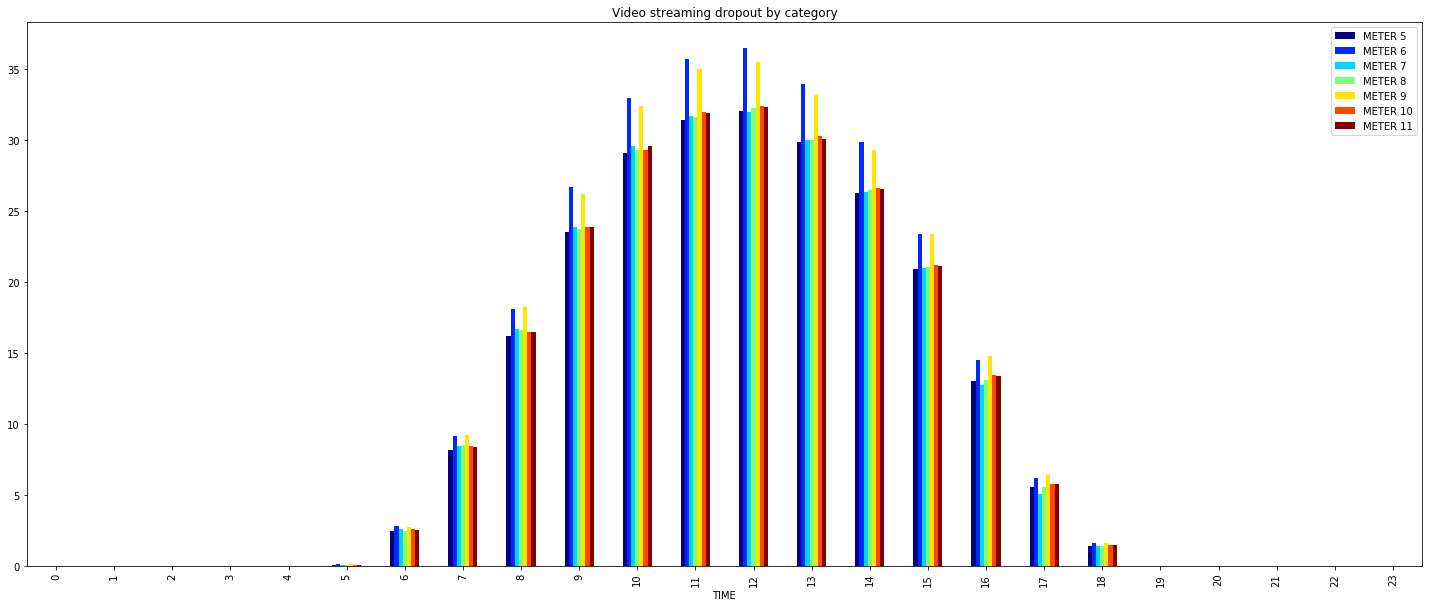

In [36]:
df_all.plot.bar(figsize=(25,10), lw=2, colormap='jet', title='Video streaming dropout by category')

<Figure size 2880x2880 with 0 Axes>

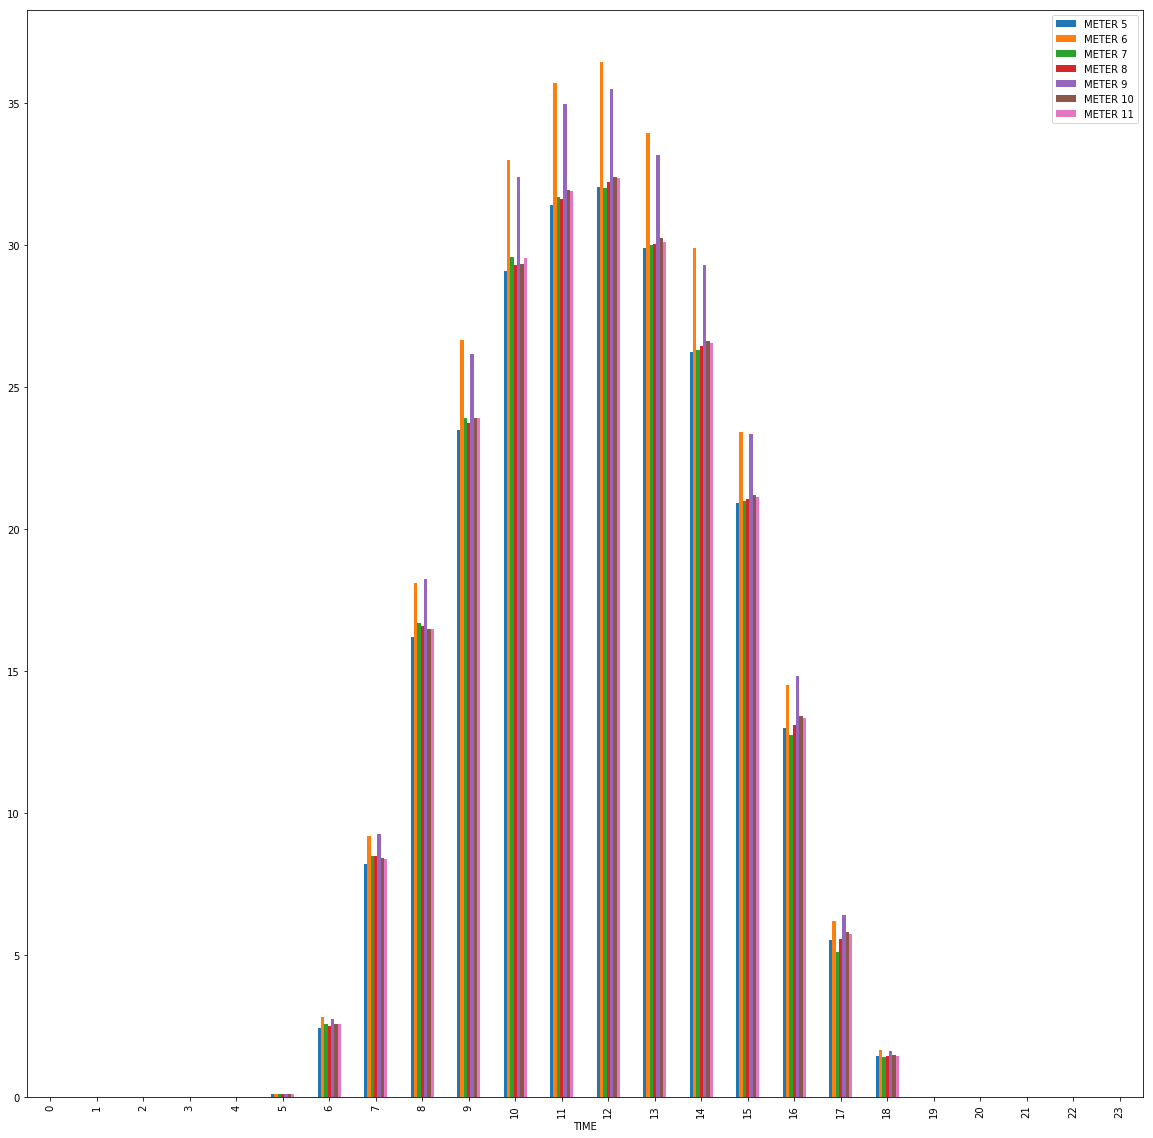

In [37]:
plt.figure(figsize=(40,40))
df_all.plot.bar(figsize=(20,20))

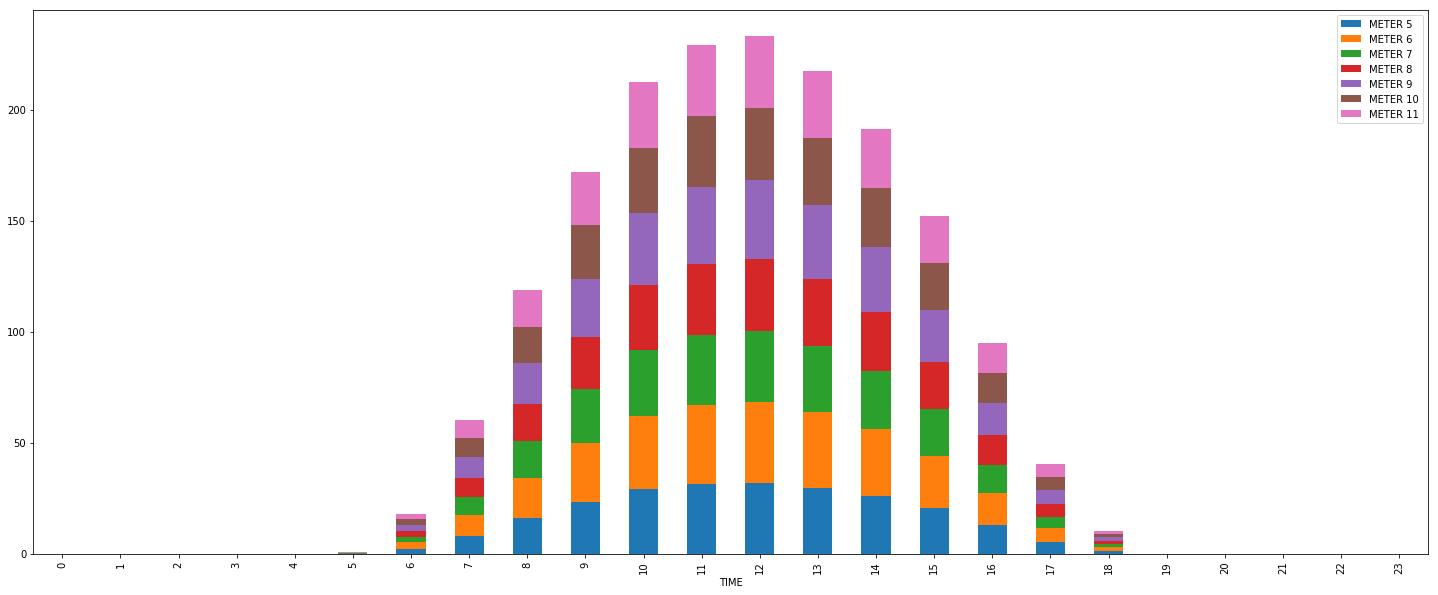

In [38]:
df_all.plot.bar(stacked=True, figsize=(25,10))

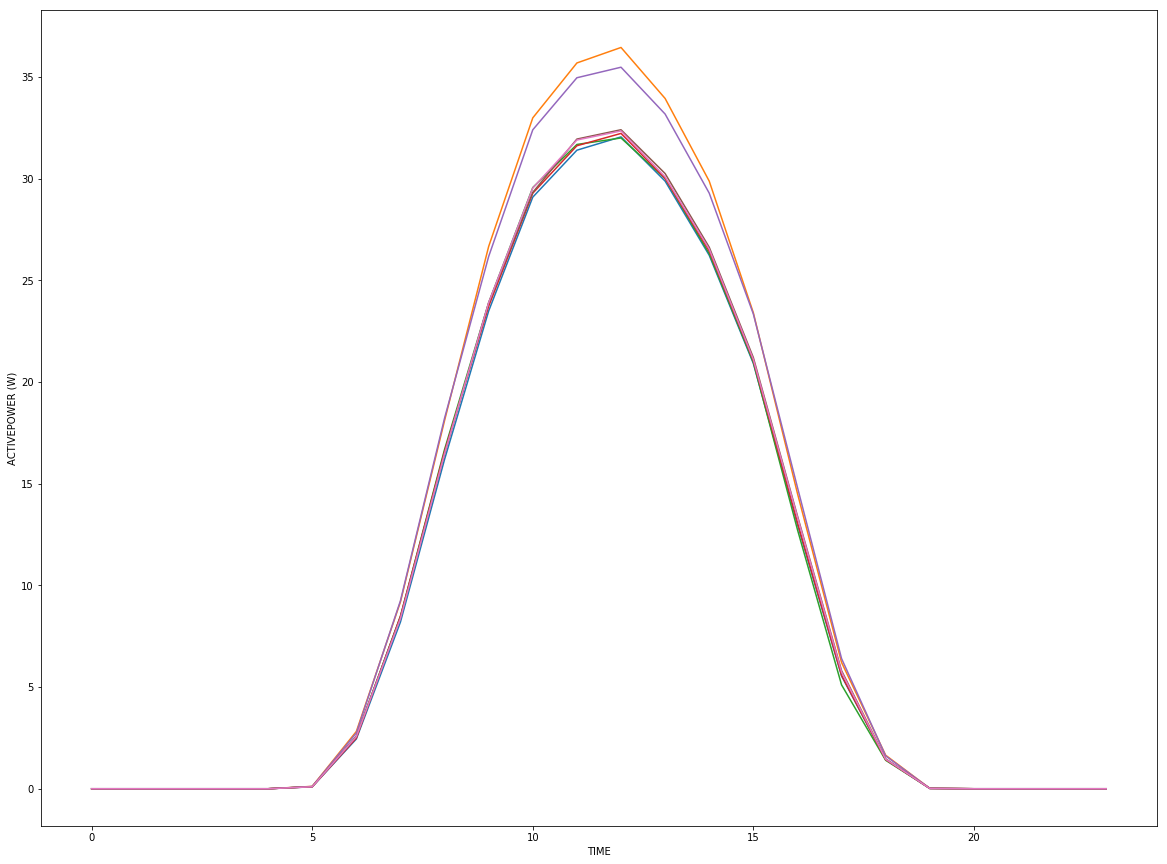

In [39]:
plt.figure(figsize=(20,15))
plt.plot(df_all)
plt.ylabel('ACTIVEPOWER (W)')
plt.xlabel('TIME')
#plt.legend()
plt.show()

In [40]:
df_all = df_all.iloc[5:20,:]
df_all

,METER 5,METER 6,METER 7,METER 8,METER 9,METER 10,METER 11
TIME,,,,,,,
5,0.094208,0.116251,0.104840,0.097469,0.111419,0.101527,0.098187
6,2.448483,2.817372,2.579298,2.495292,2.744587,2.578230,2.565736
7,8.199740,9.191541,8.475755,8.493228,9.247215,8.431034,8.376415
8,16.199345,18.108701,16.689257,16.598844,18.228358,16.465627,16.485126
9,23.499803,26.675017,23.911452,23.732831,26.181058,23.895394,23.911177
10,29.099975,32.998441,29.570375,29.293395,32.411281,29.335673,29.548076
11,31.408116,35.698996,31.690040,31.626897,34.971452,31.955199,31.909198
12,32.062818,36.461429,32.009363,32.233726,35.489741,32.414360,32.354890
13,29.887386,33.952879,30.014821,30.023953,33.186289,30.260476,30.093091


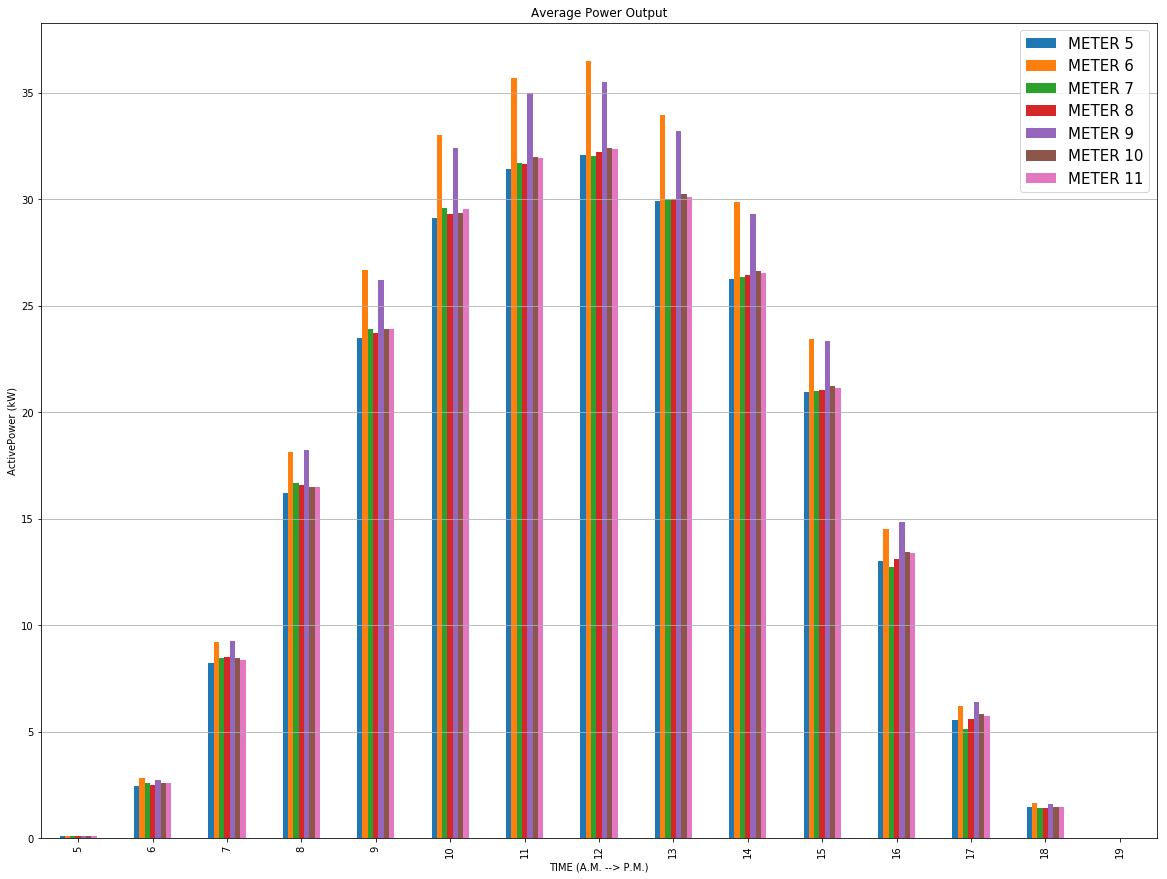

In [41]:
ax = df_all.plot.bar(figsize=(20,15), title='Average Power Output')
#start, end = ax.get_ylim()
#ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)")
ax.set_ylabel("ActivePower (kW)")
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

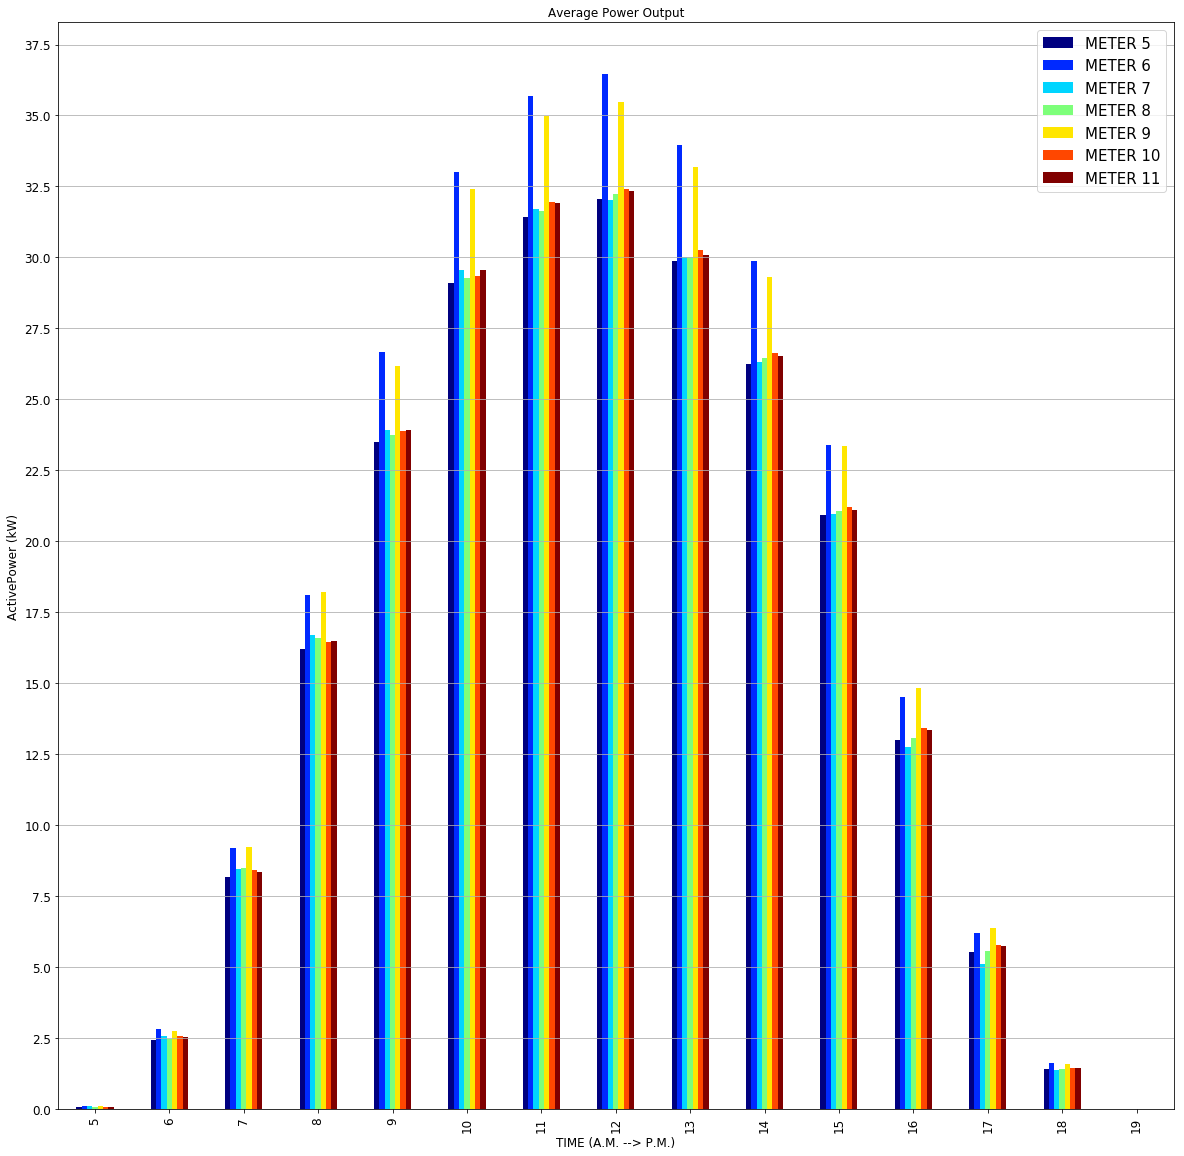

In [42]:
ax = df_all.plot.bar(figsize=(20,20), title='Average Power Output', fontsize='large', colormap='jet')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
ax.set_ylabel("ActivePower (kW)", fontsize='large')
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

In [43]:
df_solar = get_data_for_corresponding_meter('5', start_date, df_irr)
df_solar

(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


,ACTIVEPOWER,IRRADIANCE
TIME,,
2018-05-28 18:34:00,1.116,36.0
2018-05-28 18:35:00,1.059,35.0
2018-05-28 18:36:00,1.018,34.0
2018-05-28 18:37:00,0.969,33.0
2018-05-28 18:38:00,0.930,32.0
2018-05-28 18:39:00,0.885,31.0
2018-05-28 18:40:00,0.837,30.0
2018-05-28 18:41:00,0.798,29.0
2018-05-28 18:42:00,0.747,28.0


In [44]:
df_max_min = df_solar.resample('H')['ACTIVEPOWER'].agg(['min', 'max'])
df_max_min

,min,max
TIME,,
2018-05-28 18:00:00,0.056000,1.116000
2018-05-28 19:00:00,0.000000,0.013000
2018-05-28 20:00:00,0.000000,0.000000
2018-05-28 21:00:00,0.000000,0.000000
2018-05-28 22:00:00,0.000000,0.000000
2018-05-28 23:00:00,0.000000,0.000000
2018-05-29 00:00:00,0.000000,0.000000
2018-05-29 01:00:00,0.000000,0.000000
2018-05-29 02:00:00,0.000000,0.000000


In [45]:
df_hour_max_min = pd.DataFrame()
#df_hour_max_min['MAX'] = df_max_min.groupby(df_max_min.index.hour).max()["max"]
df_hour_max_min['MAX'] = df_max_min['max'].groupby(df_max_min.index.hour).mean()

#df_hour_max_min['MIN'] = df_max_min.groupby(df_max_min.index.hour).min()["min"]
df_hour_max_min['MIN'] = df_max_min['min'].groupby(df_max_min.index.hour).mean()

df_hour_max_min

,MAX,MIN
TIME,,
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
5,0.626548,0.000000
6,4.662581,0.615129
7,12.655065,4.298903
8,21.265742,11.246742


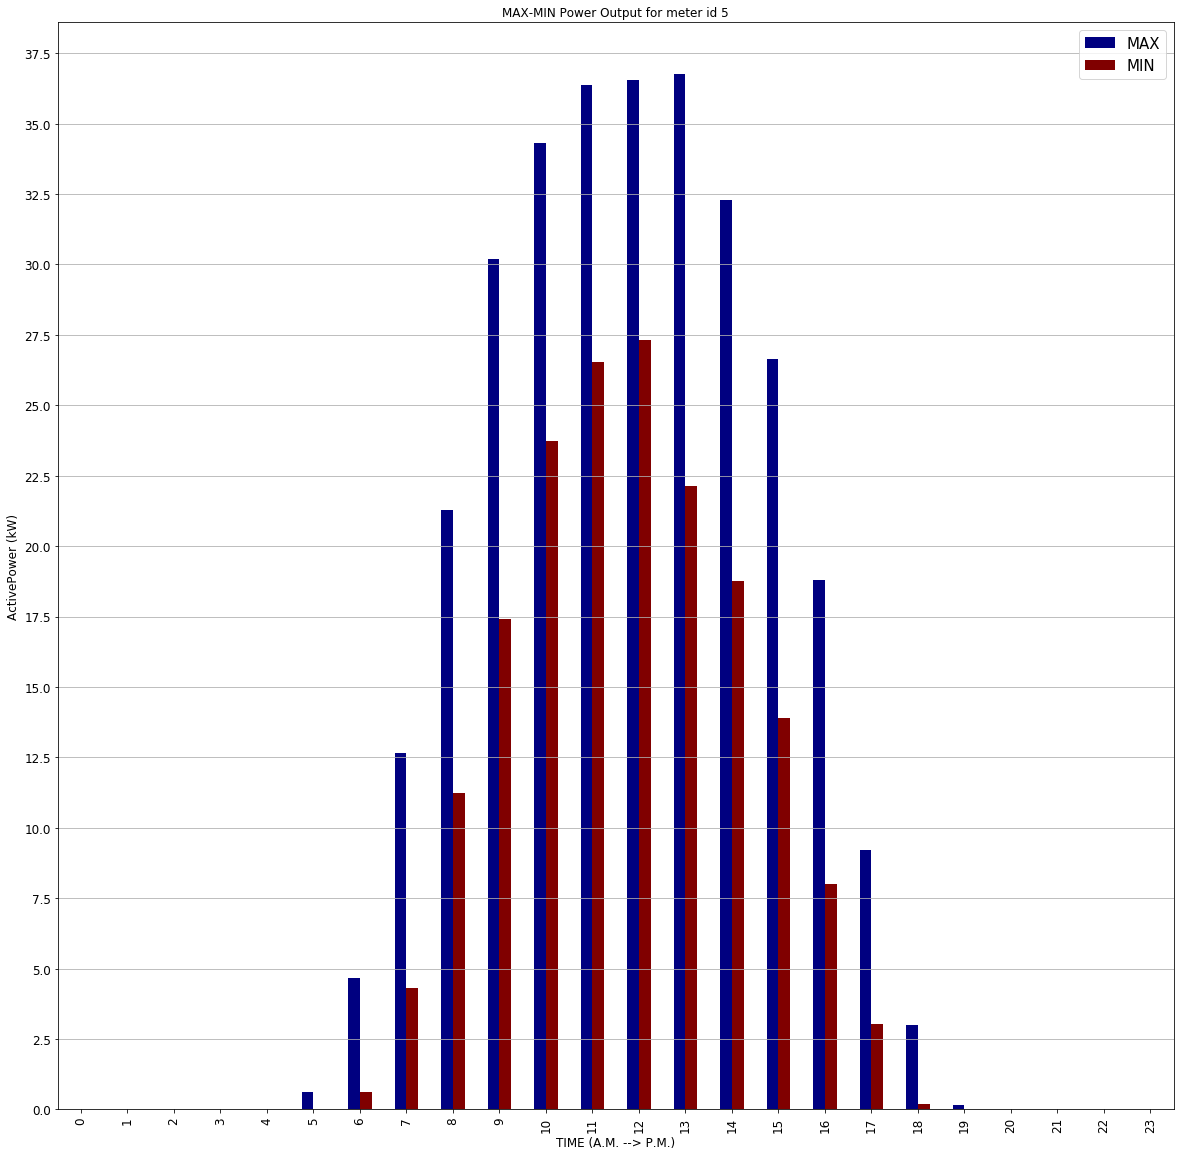

In [46]:
ax = df_hour_max_min.plot.bar(figsize=(20,20), title='MAX-MIN Power Output for meter id ' + '5', fontsize='large', colormap='jet')
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 2.5))
ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
ax.set_ylabel("ActivePower (kW)", fontsize='large')
ax.yaxis.grid(True)
#ax.grid(zorder=0)
ax.legend(loc='best', fontsize=15)

In [47]:
#df_max_min.between_time('07:00:00','07:00:00')

In [48]:
meter_hour_max_min_df_dict = get_max_min_ACTIVEPOWER_hourly(meter_ids, start_date, df_irr)
for meter_id, df in meter_hour_max_min_df_dict.items():
    print (meter_id)
    print (df)

5
(52729, 5)
(44072, 5)
(44072, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00'], dtype='datetime64[ns]', name='TIME', freq=None)
1
0
(44071, 1)
(44205, 1)
6


/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bosch/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  """


(52729, 5)
(44073, 5)
(44073, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-06-17 06:07:00', '2018-06-17 07:11:00',
               '2018-06-17 14:21:00', '2018-06-17 14:30:00',
               '2018-06-17 15:47:00', '2018-06-17 18:40:00',
               '2018-06-18 08:28:00', '2018-06-18 09:05:00'],
              dtype='datetime64[ns]', name='TIME', freq=None)
8
0
(44065, 1)
(44205, 1)
7
(52729, 5)
(44071, 5)
(44071, 2)
Empty DataFrame
Columns: [TIME, ACTIVEPOWER]
Index: []
DatetimeIndex(['2018-05-31 16:55:00', '2018-06-01 04:02:00',
               '2018-06-01 04:06:00', '2018-06-01 04:14:00',
               '2018-06-01 10:30:00', '2018-06-16 18:56:00',
               '2018-06-16 18:59:00', '2018-06-16 20:47:00',
               '2018-06-16 23:13:00', '2018-06-17 01:06:00',
               '2018-06-17 01:23:00', '2018-06-17 01:25:00',
               '2018-06-17 03:49:00', '2018-06-17 05:35:00',
               '2018-06-17 05:54:00', '2018-06-17 05:57:00',
 

      MAX ACTIVEPOWER  MIN ACTIVEPOWER
TIME                                  
0               0.000         0.000000
1               0.000         0.000000
2               0.000         0.000000
3               0.000         0.000000
4               0.000         0.000000
5               1.489         0.000000
6               7.169         0.000000
7              17.004         0.380000
8              26.627         1.921000
9              40.246         0.000000
10             45.836         0.000000
11             46.703         7.978000
12             49.647         7.962000
13             46.629         0.000000
14             44.084         5.518000
15             33.150         0.000000
16             25.482         1.695437
17             13.663         0.000000
18              5.059         0.000000
19              0.706         0.000000
20              0.000         0.000000
21              0.000         0.000000
22              0.000         0.000000
23              0.000    

In [49]:
def show_plot_max_min_meters(meter_hour_max_min_df_dict):
    for meter_id, df in meter_hour_max_min_df_dict.items():
        ax = df.plot.bar(figsize=(20,20), title='MAX-MIN Power Output for meter id ' + meter_id, fontsize='large', colormap='jet')
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, 2.5))
        ax.set_xlabel("TIME (A.M. --> P.M.)", fontsize='large')
        ax.set_ylabel("ActivePower (kW)", fontsize='large')
        ax.yaxis.grid(True)
        #ax.grid(zorder=0)
        ax.legend(loc='best', fontsize=15)

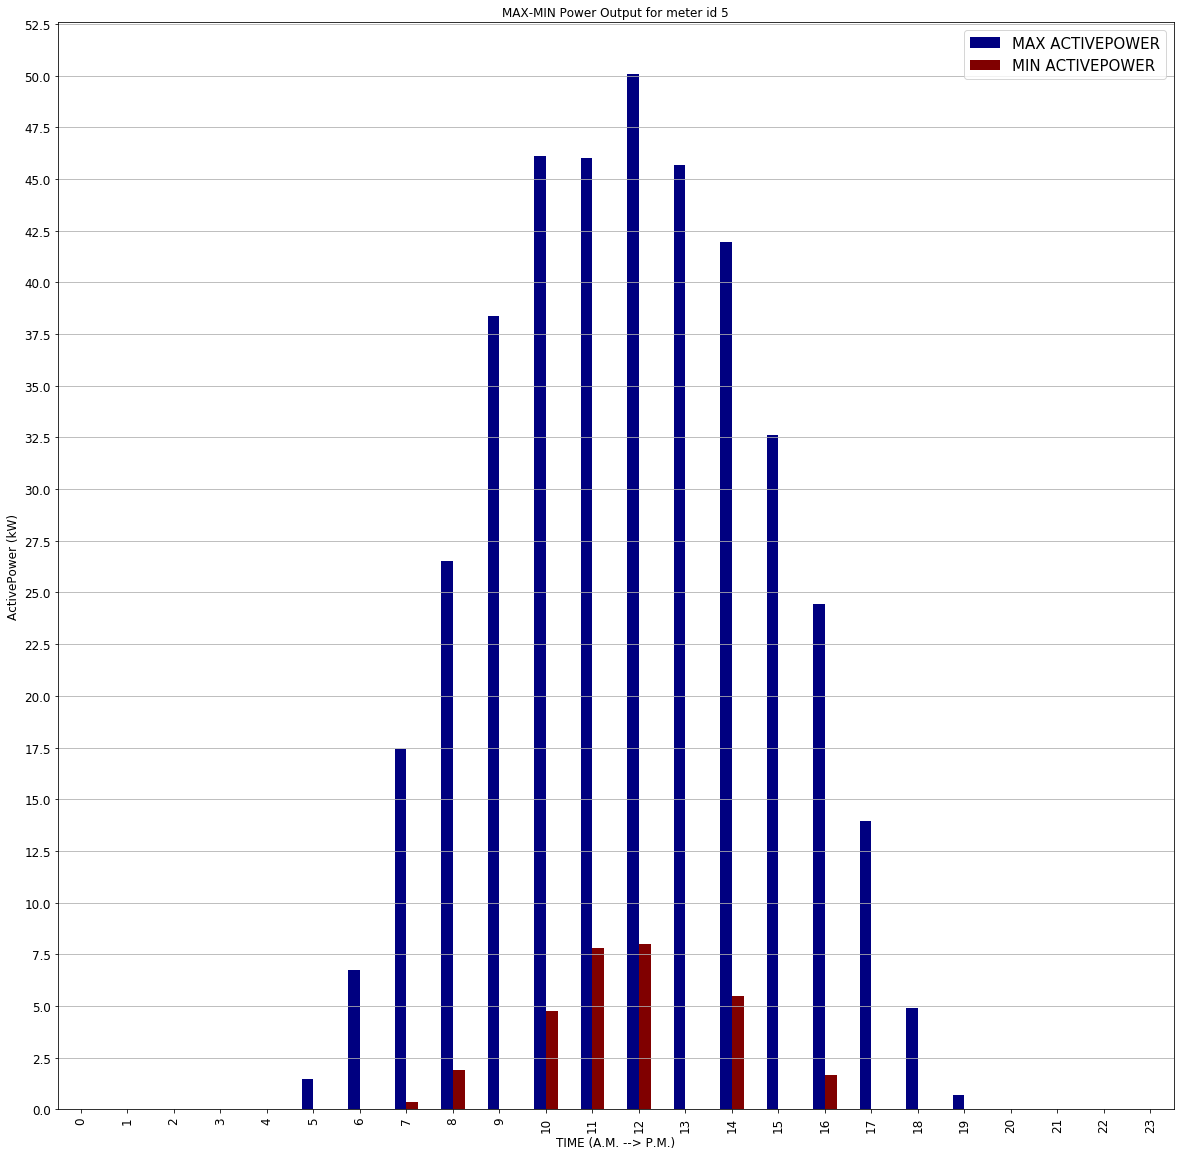

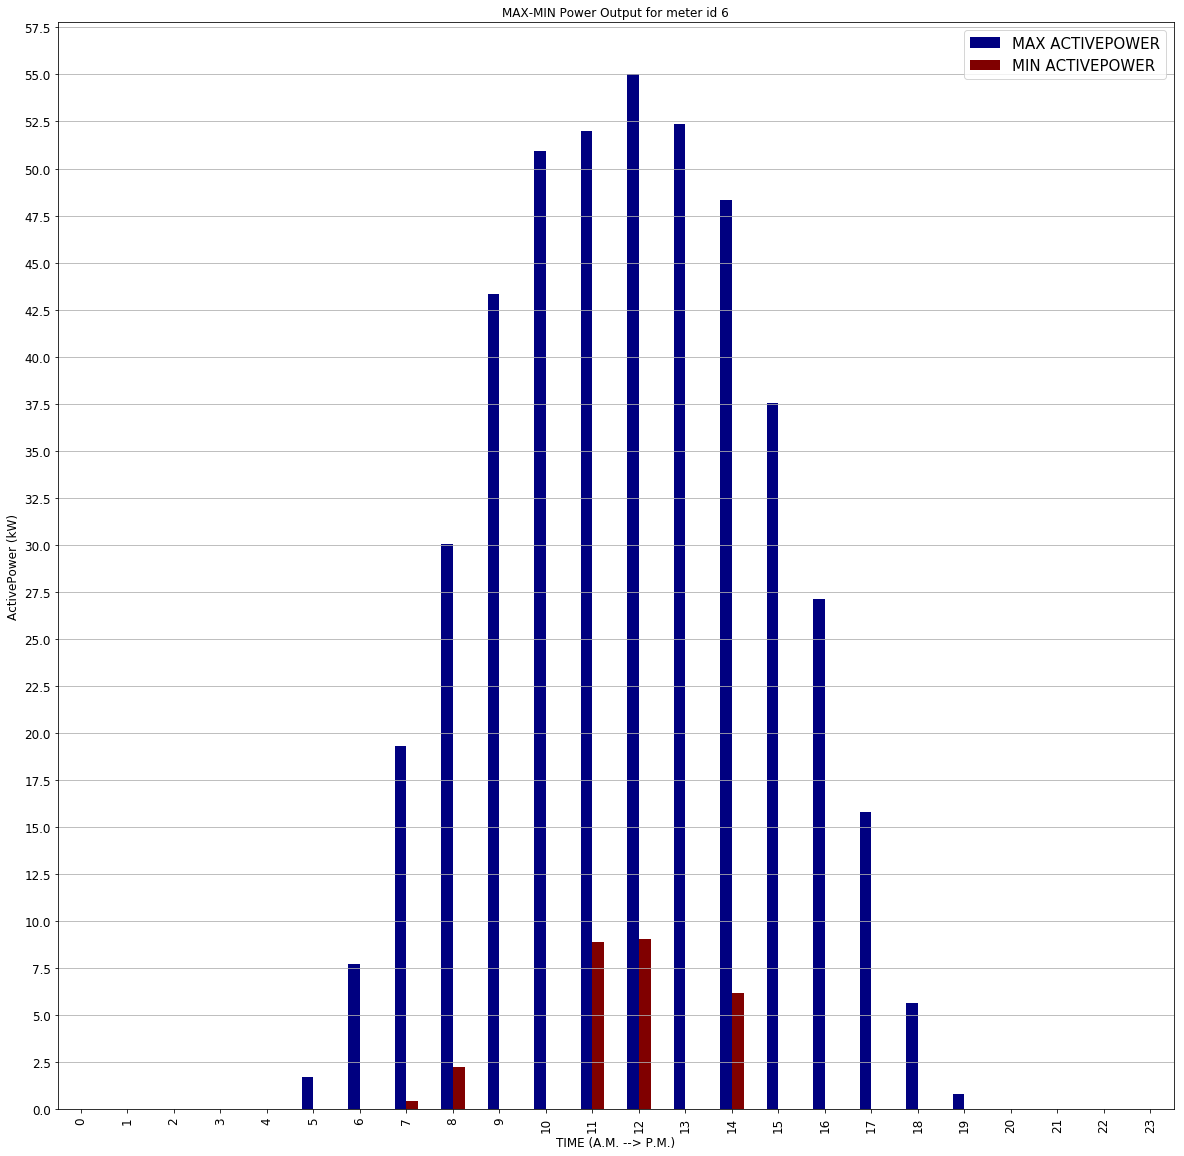

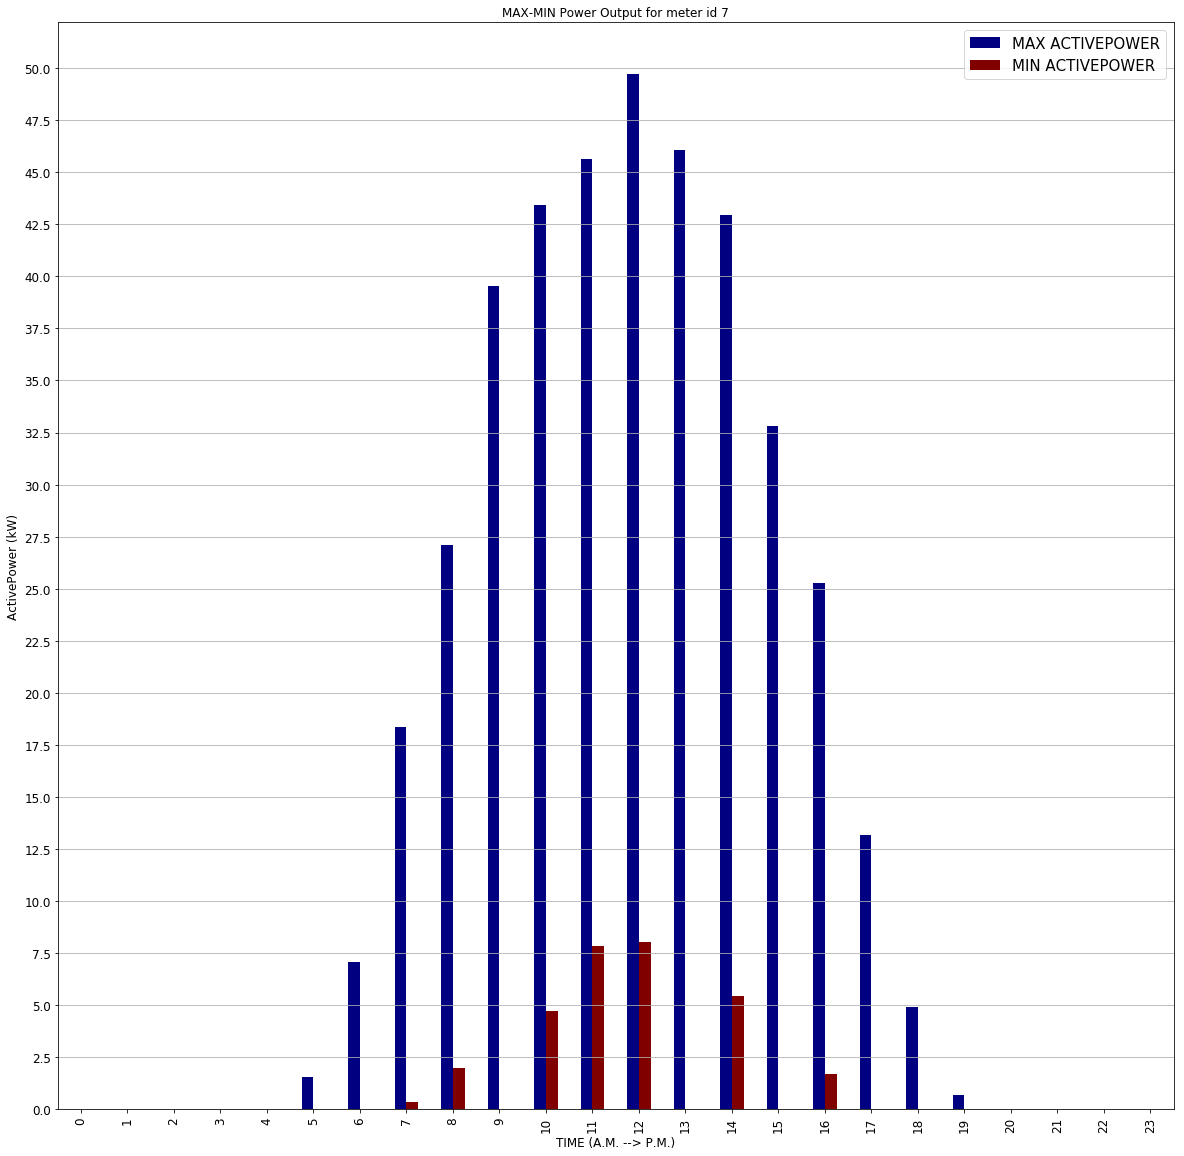

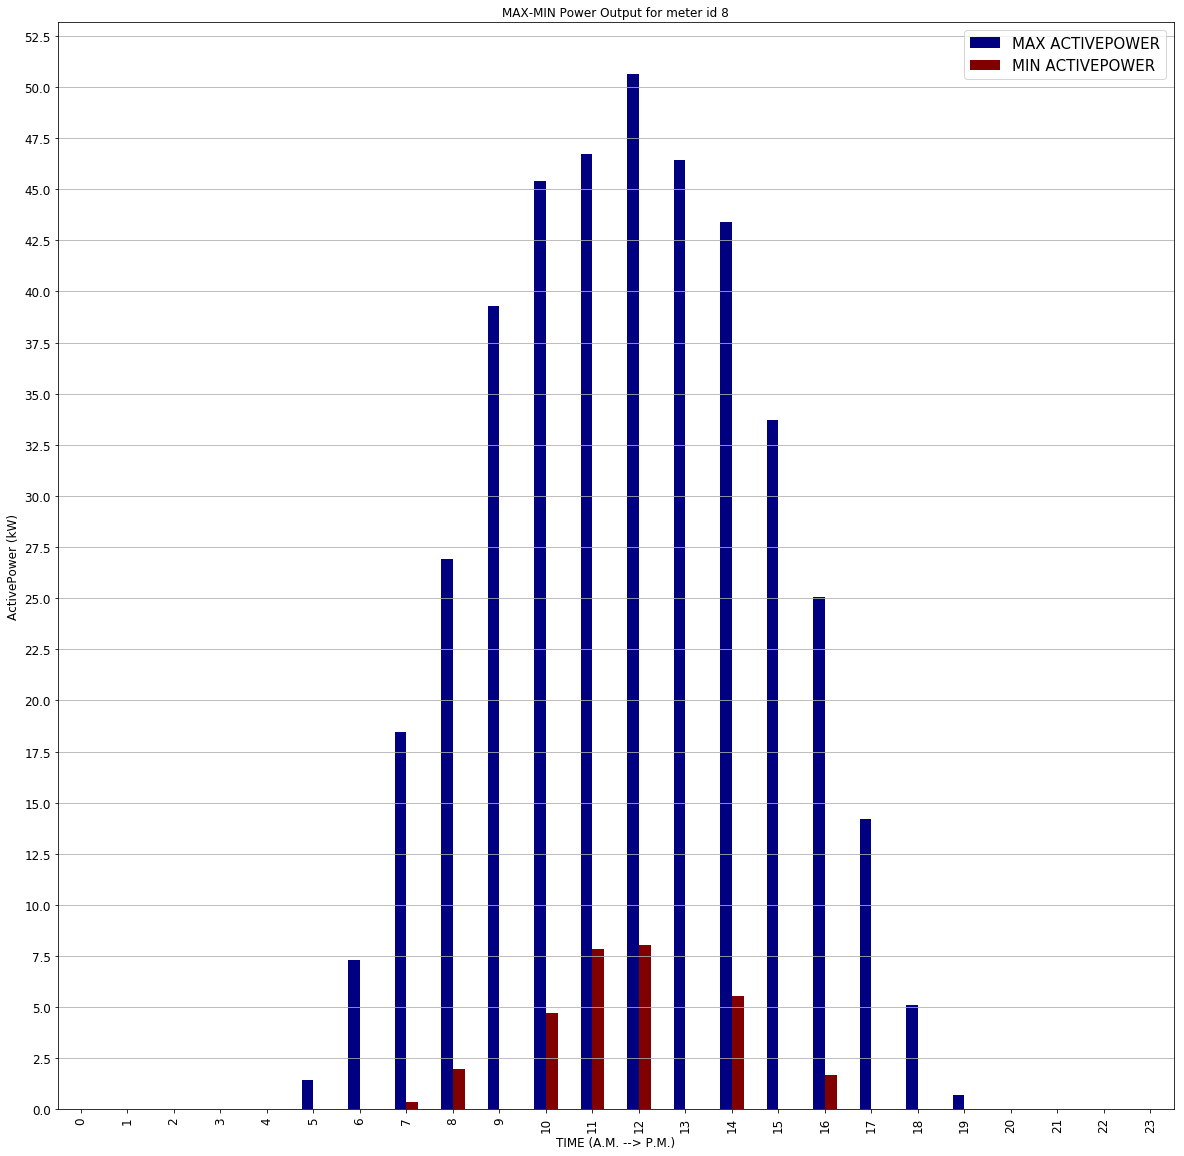

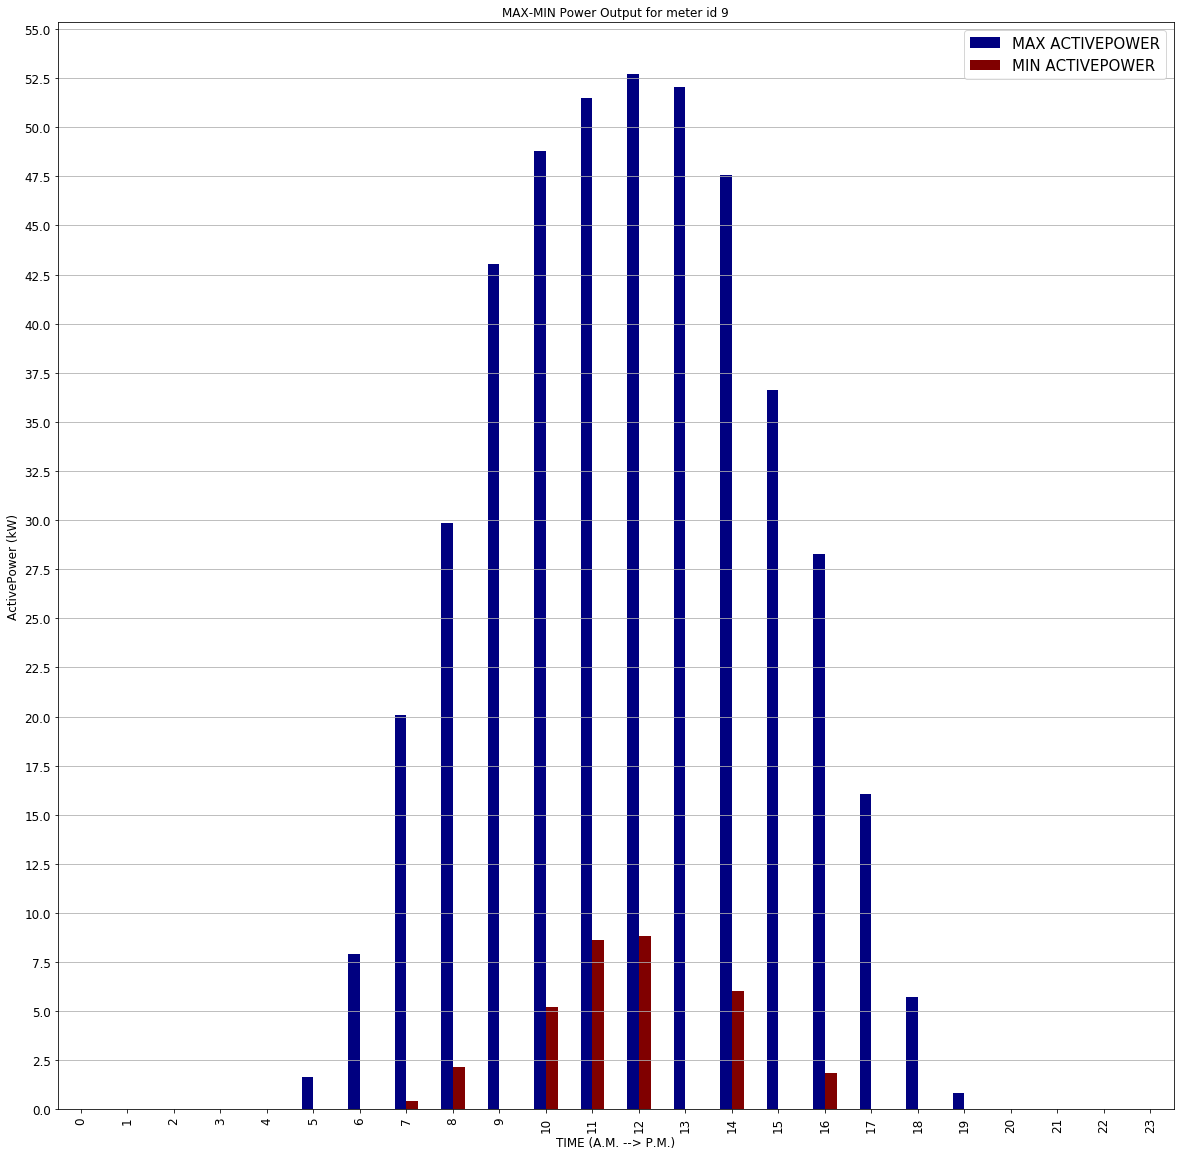

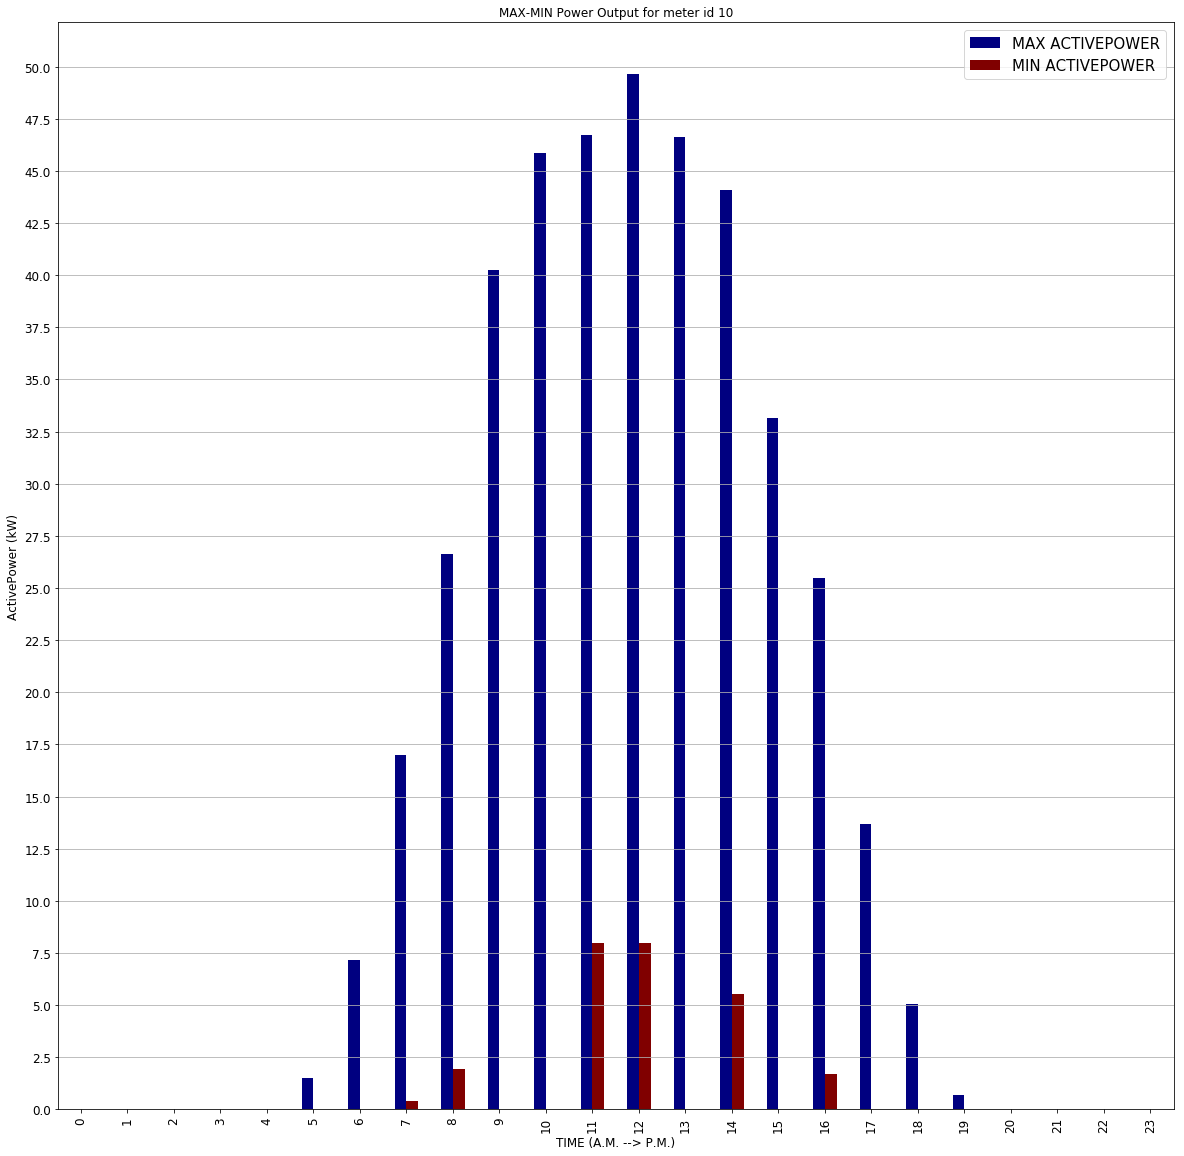

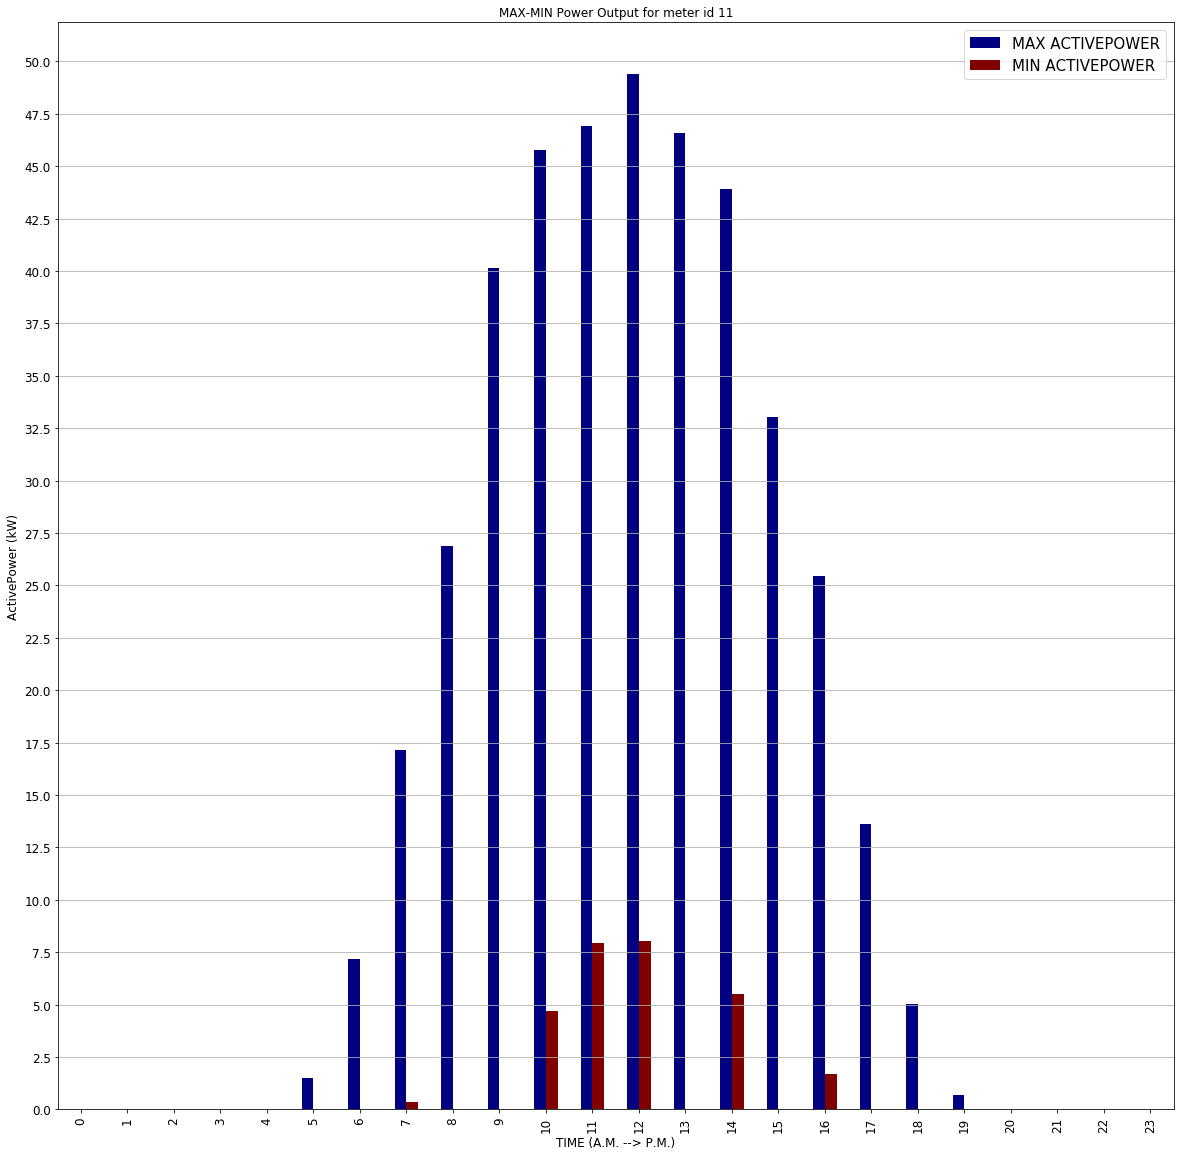

In [50]:
show_plot_max_min_meters(meter_hour_max_min_df_dict)